Данные работы системы ОАИСКГ на ПС XXXXX 			
			
Описание системы			
	ОАИСКГ - система контроля гололеда на проводах ВЛ. Состоит из оптических датчиков тяжения и температуры, оптического волокна, интеррогатора (оптический регистрирующий блок) и ПО для получения измерений		
	Датчики установлены распределенно - на расстоянии до несколько десятков км друг от друга.		
	Исходная частота получения данных - 10Гц, для выдачи на сервер системы они усредняются с периодом 10сек.		
			
Описание данных			
	Данные интегрированы в блоки по 10 минут. Каждый блок (строка таблицы) начинается с времени начала блока (время местное)		
	Далее следуют пакеты измерений от каждого датчика. В пакете следующие данные		
		N - количество исходных измерений в пакете	
		T - средняя температура датчика, ˚С	
		T_std - СКО температуры датчика, ˚С	
		Fav - среднее тяжение, Н	
		Fav_std - СКО тяжения, Н	
		Fbend - средний изгиб датчика, Н	
		Fbend_std - СКО изгиба датчика, Н	
		Ice - эквивалентный гололед, мм	
		Ice_std - СКО эквивалентного гололеда, мм	
		Fnorm_min - минимальное нормальное тяжение в пролете, Н	
		Fnorm_max - максимальное нормальное тяжение в пролете, Н	
			нормальное тяжение определяется по текущей модели пролета, зависит от температуры


Анализ данных (вторая редакция, без секретов)

Конаков К.Г.

2020 08 20

### Executive Summary

* Проведена загрузка 17 тысяч записей с датчиков с 10 датчиков, 110 колонок с данными
* Для первичного изучения отброшены данные, где в интервале 10 минут есть пропуски записей
* В работе применен метод декомпозиции временных рядов. Выделен тренд и сезонная (недельная)составляющая
* Особое внимание обращено на выброс Fbend_std. Показано, что это выброс происходит практически одновременно на трех датчиках
* В плане:  
* Стадия A)корреляционный анализ, elbow, кластеризация по первому датчику
* ревью КК
* Стадия Б) после подтверждения аналогичный анализ по остальным датчикам
* сдача результата Заказчику
* Возможно продолжение работы в двух направлениях:
    * А) изучение и интерпретация выбросов других параметров. Возможно, на сырых, не усредненных данных.
    * Б) формирование признаков и тренировка модели, которая уменьшит число "ложных тревог". То есть система покажет жёлтый свет, если гололед начал образовываться, но вероятнее всего сам растает

## 1. Загрузка данных

In [1]:
import pandas as pd
# Загрузим тестовые данные с усреднением 10 минут
df = pd.read_excel('C:\___Konakov_work\TOG20_1_10min_headers.xlsx', header = 2, index_col=0)

In [2]:
df.head() # изучим начало датасета

,N_Sensor12-11,T_Sensor12-11,T_std_Sensor12-11,Fav_Sensor12-11,Fav_std_Sensor12-11,Fbend_Sensor12-11,Fbend_std_Sensor12-11,Ice_Sensor12-11,Ice_std_Sensor12-11,Fnorm_min_Sensor12-11,...,T_Sensor12-20,T_std_Sensor12-20,Fav_Sensor12-20,Fav_std_Sensor12-20,Fbend_Sensor12-20,Fbend_std_Sensor12-20,Ice_Sensor12-20,Ice_std_Sensor12-20,Fnorm_min_Sensor12-20,Fnorm_max_Sensor12-20
DateTime,,,,,,,,,,,,,,,,,,,,,
2020-01-01 00:00:00,100.0,-2.292167,0.006583,8781.619650,15.540450,-5.726400,0.015850,1.029383,0.030083,7788.526550,...,-2.010700,0.008600,5224.544817,19.855717,-0.151167,0.021833,0.201350,0.046900,4707.054967,5573.700783
2020-01-01 00:10:00,100.0,-2.267683,0.007567,8775.583017,16.167100,-5.721750,0.015800,1.020233,0.031200,7787.369067,...,-1.985900,0.008750,5227.373650,20.580400,-0.128617,0.019967,0.209217,0.048517,4706.563467,5573.200850
2020-01-01 00:20:00,100.0,-2.238517,0.006250,8772.642833,14.954567,-5.723217,0.015883,1.017650,0.029050,7785.530467,...,-1.942867,0.008617,5225.645767,20.491267,-0.114183,0.020600,0.207133,0.048317,4705.689333,5572.352700
2020-01-01 00:30:00,100.0,-2.204450,0.006767,8772.006050,14.743733,-5.722717,0.013733,1.020133,0.028517,7783.651267,...,-1.889117,0.008583,5225.028000,20.296617,-0.111317,0.019850,0.208267,0.047717,4704.611600,5571.248983
2020-01-01 00:40:00,100.0,-2.161767,0.006433,8768.819700,15.115983,-5.717350,0.014950,1.018617,0.029283,7781.330650,...,-1.839950,0.008533,5224.257550,20.592100,-0.114717,0.019500,0.208767,0.048433,4703.629850,5570.269750


In [3]:
df.info() # общая информация о датасете и объеме занимаемой памяти

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 16929 entries, 2020-01-01 00:00:00 to 2020-04-29 10:50:00
Columns: 110 entries, N_Sensor12-11 to Fnorm_max_Sensor12-20
dtypes: float64(110)
memory usage: 14.3 MB


In [4]:
if df.index.is_monotonic: # проверим на монотонность
    print('Данные монотонны')
else:
    print('Данные не монотонны, сортирую')
    df.sort_index(inplace=True)
    print(df.info())

Данные монотонны


In [5]:
df.columns #list of all columns

Index(['N_Sensor12-11', 'T_Sensor12-11', 'T_std_Sensor12-11',
       'Fav_Sensor12-11', 'Fav_std_Sensor12-11', 'Fbend_Sensor12-11',
       'Fbend_std_Sensor12-11', 'Ice_Sensor12-11', 'Ice_std_Sensor12-11',
       'Fnorm_min_Sensor12-11',
       ...
       'T_Sensor12-20', 'T_std_Sensor12-20', 'Fav_Sensor12-20',
       'Fav_std_Sensor12-20', 'Fbend_Sensor12-20', 'Fbend_std_Sensor12-20',
       'Ice_Sensor12-20', 'Ice_std_Sensor12-20', 'Fnorm_min_Sensor12-20',
       'Fnorm_max_Sensor12-20'],
      dtype='object', length=110)

In [6]:
first_sensor_column = [col for col in df.columns if 'Sensor12-11' in col] # выберем только столбцы от первого датчика

In [7]:
first_sensor_column # Изучим эти столбцы

['N_Sensor12-11',
 'T_Sensor12-11',
 'T_std_Sensor12-11',
 'Fav_Sensor12-11',
 'Fav_std_Sensor12-11',
 'Fbend_Sensor12-11',
 'Fbend_std_Sensor12-11',
 'Ice_Sensor12-11',
 'Ice_std_Sensor12-11',
 'Fnorm_min_Sensor12-11',
 'Fnorm_max_Sensor12-11']

In [8]:
df1 = df[first_sensor_column]# выберем только данные первого датчика 

In [9]:
# уберем интервалы с пропущенными записями
df1 = df1.drop(df1[(df1['N_Sensor12-11'] < 100) ].index)

In [10]:
df1s = df1.iloc[:6000,:].copy() # скопируем превую треть данных - зима

In [11]:
df1s.info() # checking that there are no empty cells

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 6000 entries, 2020-01-01 00:00:00 to 2020-02-11 19:50:00
Data columns (total 11 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   N_Sensor12-11          6000 non-null   float64
 1   T_Sensor12-11          6000 non-null   float64
 2   T_std_Sensor12-11      6000 non-null   float64
 3   Fav_Sensor12-11        6000 non-null   float64
 4   Fav_std_Sensor12-11    6000 non-null   float64
 5   Fbend_Sensor12-11      6000 non-null   float64
 6   Fbend_std_Sensor12-11  6000 non-null   float64
 7   Ice_Sensor12-11        6000 non-null   float64
 8   Ice_std_Sensor12-11    6000 non-null   float64
 9   Fnorm_min_Sensor12-11  6000 non-null   float64
 10  Fnorm_max_Sensor12-11  6000 non-null   float64
dtypes: float64(11)
memory usage: 562.5 KB


In [12]:
df1s.describe() #study percentiles

,N_Sensor12-11,T_Sensor12-11,T_std_Sensor12-11,Fav_Sensor12-11,Fav_std_Sensor12-11,Fbend_Sensor12-11,Fbend_std_Sensor12-11,Ice_Sensor12-11,Ice_std_Sensor12-11,Fnorm_min_Sensor12-11,Fnorm_max_Sensor12-11
count,6000.000000,6000.000000,6000.000000,6000.000000,6000.000000,6000.000000,6000.000000,6000.000000,6000.000000,6000.000000,6000.000000
mean,100.000842,-5.811072,0.013423,9407.572993,24.057464,-6.168562,0.028276,1.182860,0.039492,8324.718377,9300.670126
std,0.003650,4.270418,0.097638,613.875484,64.444635,0.294913,0.055591,1.050249,0.023026,316.797977,315.379378
min,100.000000,-20.155150,0.005400,2138.157433,11.323317,-7.634767,0.005750,0.169550,0.020783,7701.045183,8678.178667
25%,100.000000,-8.154975,0.006867,9013.689625,14.432846,-6.318642,0.011200,0.582579,0.027650,8147.599271,9124.646433
50%,100.000000,-4.824542,0.007617,9225.897450,16.481900,-6.092867,0.017942,0.797008,0.031600,8312.748317,9289.541100
75%,100.000000,-2.682979,0.008550,9642.631412,21.820458,-5.991237,0.034054,1.400650,0.041750,8511.254967,9486.422704
max,100.016667,0.916367,4.528317,11618.491683,2723.970417,-1.719617,2.199933,5.678267,0.251850,9212.978417,10187.804400


## 2. Исследовательский анализ данных

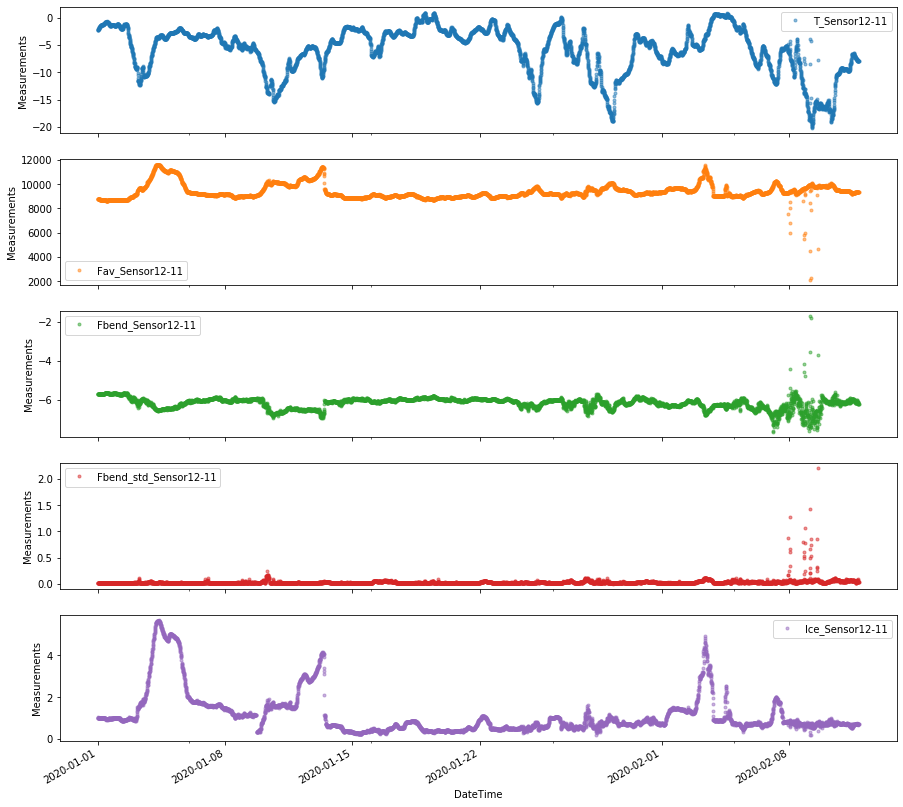

In [14]:
import matplotlib.pyplot as plt
%matplotlib inline
cols_plot = ['T_Sensor12-11','Fav_Sensor12-11','Fbend_Sensor12-11','Fbend_std_Sensor12-11','Ice_Sensor12-11']
axes = df1s[cols_plot].plot(
    marker='.', alpha=0.5, linestyle='None', figsize=(15, 15), subplots=True)
for ax in axes:
    ax.set_ylabel('Measurements')

## 2.1 Анализ сезонности через декомпозицию

In [21]:
from statsmodels.tsa.seasonal import seasonal_decompose # зададим функцию декомпозиции и вывода графиков
def decomp_plot(temp):
    decomposed = seasonal_decompose(temp, period = 1000)

    plt.figure(figsize=(13, 8))
    plt.subplot(311)
# Чтобы график корректно отобразился, указываем его
# оси ax, равными plt.gca() (англ. get current axis,
# получить текущие оси)
    decomposed.trend.plot(ax=plt.gca())
    plt.title('Trend')
    plt.subplot(312)
    decomposed.seasonal.plot(ax=plt.gca())
    plt.title('Seasonality')
    plt.subplot(313)
    decomposed.resid.plot(ax=plt.gca())
    plt.title('Residuals')
    plt.tight_layout()

### Температура датчика

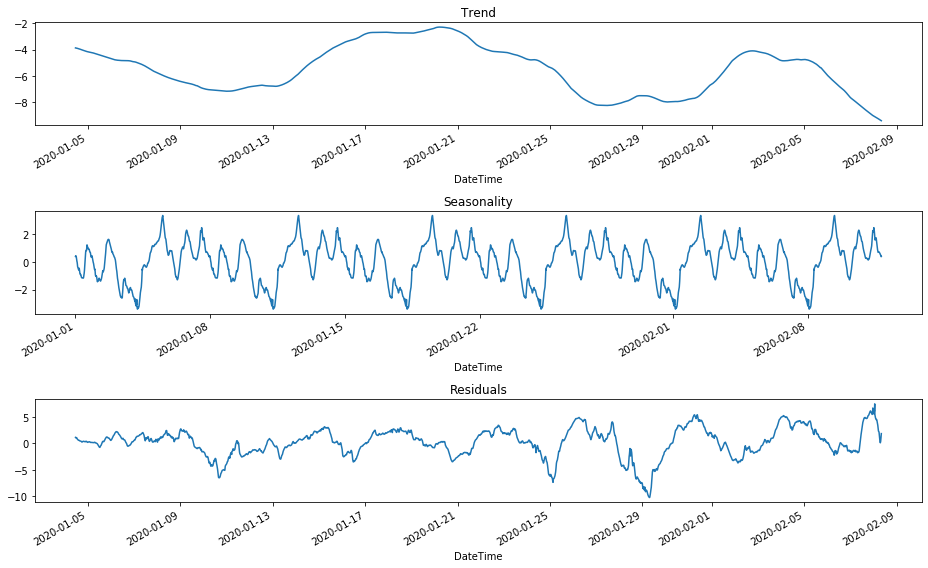

In [17]:
decomp_plot(df1s[['T_Sensor12-11']])

* "трендом" в данной ситуации является среднесуточная погода, её вклад от -8 до -2 градусов
* "сезонность" - это нагрев провода в зависимости от потребления тока - недельный цикл - даёт +/- 2 градуса
* отстатки выглядят стационарным времненным рядом, это влияние внешних факторов с размахом +/- 5 градусов

### Fav - среднее тяжение, Н

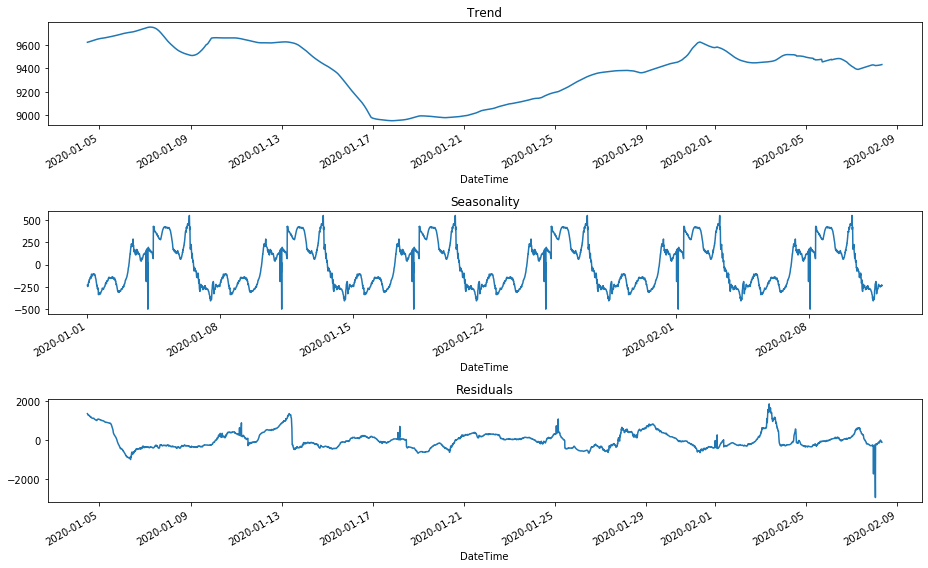

In [18]:
decomp_plot(df1s[['Fav_Sensor12-11']])

### Fbend_std - СКО изгиба датчика, Н

разработчики датчиков особо заинтересованы в анализе этой характеристики

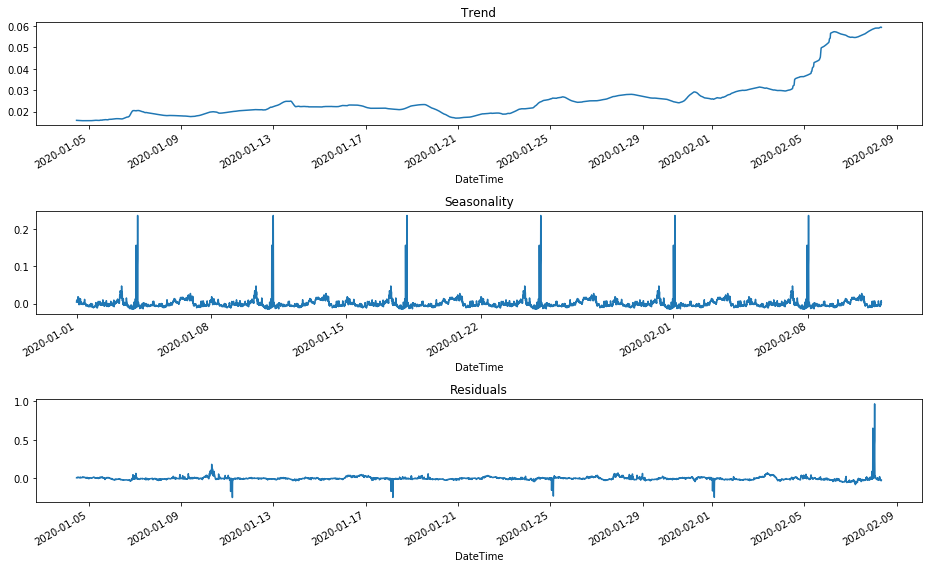

In [19]:
decomp_plot(df1s[['Fbend_std_Sensor12-11']])

* Интересно, что есть недельный цикл с заметной амплитудой. Зависимость от температуры?

### Ice - эквивалентный гололед, мм

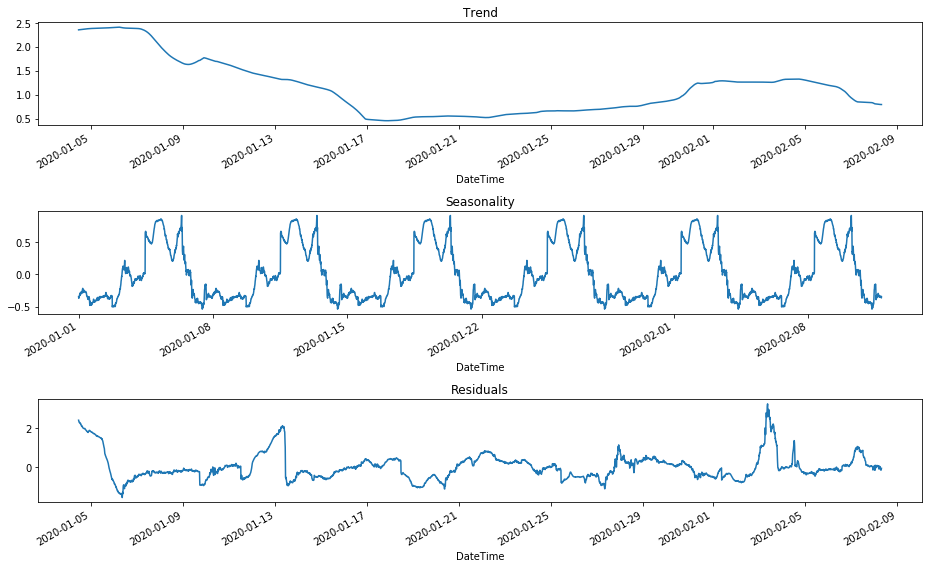

In [20]:
decomp_plot(df1s[['Ice_Sensor12-11']])

Разница всего в 1 мм, но в середине недели гололёду образоваться "труднее"

### 2.1 Графики значимых переменных

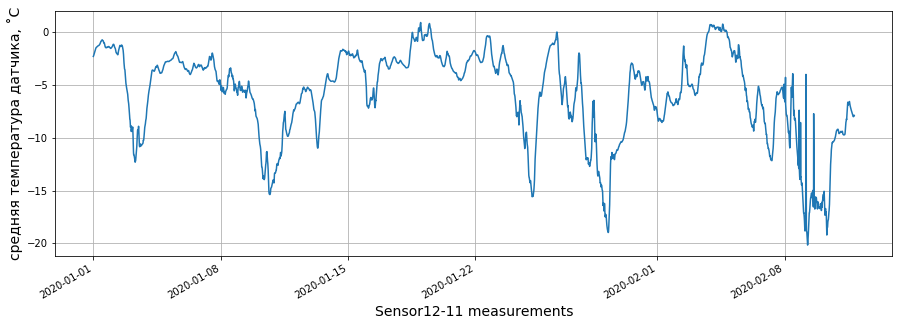

In [22]:
import matplotlib.pyplot as plt
df1s['T_Sensor12-11'].plot(figsize = (15,5),grid=True)
plt.xlabel('Sensor12-11 measurements',fontsize=14)
plt.ylabel('средняя температура датчика, ˚С',fontsize=14)
plt.show();

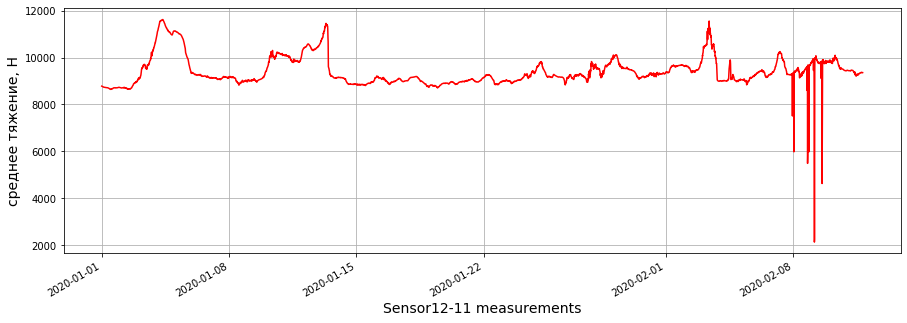

In [23]:
df1s['Fav_Sensor12-11'].plot(figsize = (15,5),grid=True,color='red')
plt.xlabel('Sensor12-11 measurements',fontsize=14)
plt.ylabel('среднее тяжение, Н',fontsize=14)
plt.show();

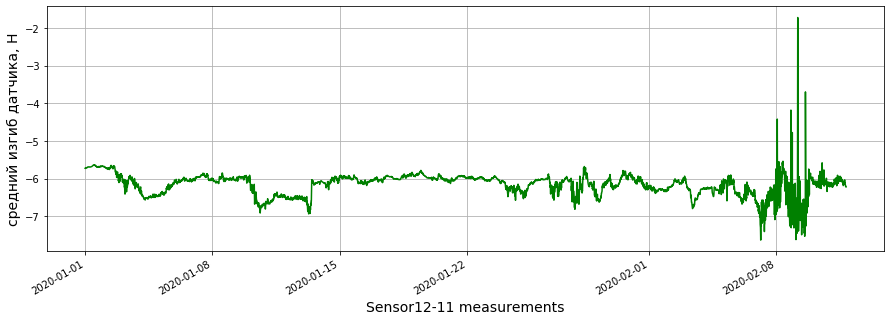

In [24]:
df1s['Fbend_Sensor12-11'].plot(figsize = (15,5),grid=True,color='green')
plt.xlabel('Sensor12-11 measurements',fontsize=14)
plt.ylabel('средний изгиб датчика, Н',fontsize=14)
plt.show();

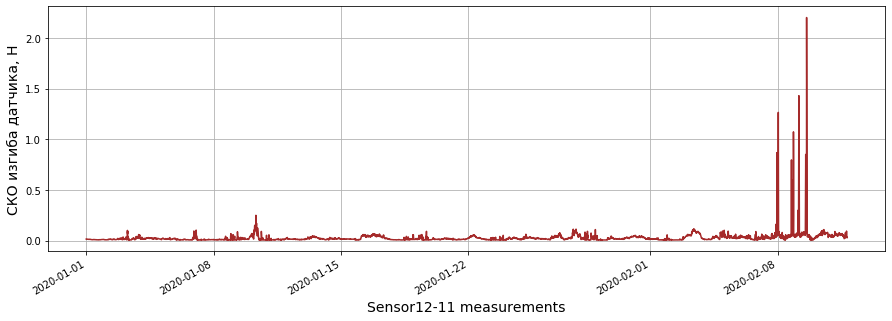

In [25]:
df1s['Fbend_std_Sensor12-11'].plot(figsize = (15,5),grid=True,color='brown')
plt.xlabel('Sensor12-11 measurements',fontsize=14)
plt.ylabel('СКО изгиба датчика, Н',fontsize=14)
plt.show();

Есть пик СКО изгиба датчика - возможно - сбой? 

### Изучим подробнее этот выброс:

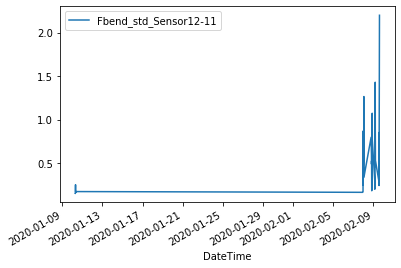

In [27]:
df1s.loc[df1s['Fbend_std_Sensor12-11'] > 0.15,['Fbend_std_Sensor12-11']].plot();

In [46]:
df1s.loc[df1s['Fbend_std_Sensor12-11'] > 0.15,['Fbend_std_Sensor12-11']]

,Fbend_std_ОДТиТ-12-11
DateTime,
2020-01-10 06:50:00,0.151450
2020-01-10 07:20:00,0.155383
2020-01-10 07:30:00,0.160717
2020-01-10 07:50:00,0.249967
2020-01-10 08:00:00,0.171317
2020-01-10 08:30:00,0.159867
2020-01-10 08:40:00,0.171317


### _А что в оригинальном датасете c Fbend_std в этот период?_

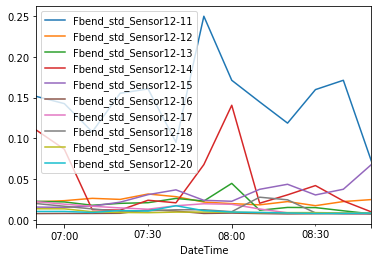

In [28]:
df.loc['2020-01-10 06:50:00':'2020-01-10 08:55:00', df.columns.str.startswith('Fbend_std')].plot();

На датчиках 11, 14 и 20 зарегистрированы пики Fbend_std в период 7:45 - 8:00 10 января.

__Возможно, был сильный порыв ветра?__

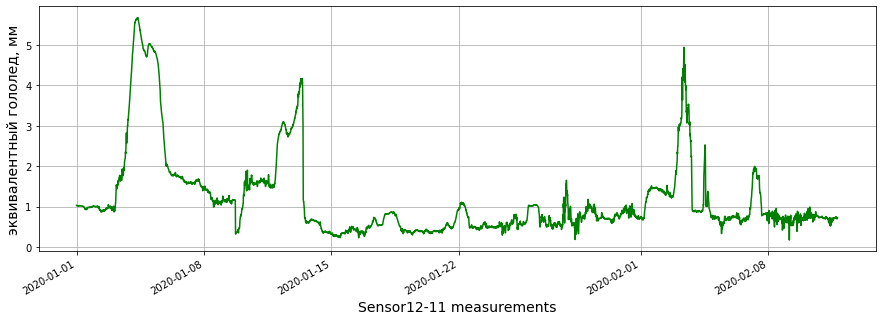

In [30]:
df1s['Ice_Sensor12-11'].plot(figsize = (15,5),grid=True,color='green')
plt.xlabel('Sensor12-11 measurements',fontsize=14)
plt.ylabel('эквивалентный гололед, мм',fontsize=14)
plt.show();


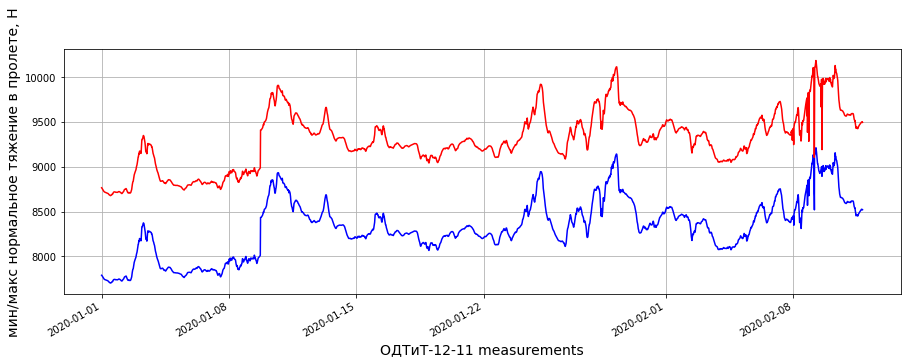

In [31]:
df1s['Fnorm_min_Sensor12-11'].plot(figsize = (15,5),grid=True,color='blue')
df1s['Fnorm_max_Sensor12-11'].plot(figsize = (15,5),grid=True,color='red')
plt.xlabel('ОДТиТ-12-11 measurements',fontsize=14)
plt.ylabel('мин/макс нормальное тяжение в пролете, Н',fontsize=14)
plt.show();

### 2.2 Кластеризация и поиск аномалий